In [ ]:
import geopandas as gpd
import pandas as pd

import mapillary as mly
#import json

import glob


import gzip

from datetime import datetime


import os
import json

In [23]:


## POINTS
# https://www.mapillary.com/developer/api-documentation/points?locale=de_DE

# --- 1) Markierungen-Definitionen  --------------------------------
cw_marking = "marking--discrete--symbol--bicycle"  # Fahrradmarkierung

# --- 2) Load Mapillary map feature points data from parquet files  --------------------------------
# Find all parquet files in the output folder (per state)
parquet_files = glob.glob("../../output/mapillary_map-feature-points_*.parquet")

# Read all files and concatenate into one GeoDataFrame
mapillary_mf_points = gpd.GeoDataFrame(
    pd.concat([gpd.read_parquet(f) for f in parquet_files], ignore_index=True),
    crs=gpd.read_parquet(parquet_files[0]).crs
)

# --- 2b) Read dataset metadata (instead of parsing dates from filenames) ---
metadata_path = os.path.join("..", "..", "output", "ml-mf_metadata.json")
ml_mf_metadata = None
ml_data_from = None
processed_date = None
bundeslaender_meta = {}

if os.path.exists(metadata_path):
    with open(metadata_path, "r", encoding="utf-8") as f:
        ml_mf_metadata = json.load(f)
    ml_data_from = ml_mf_metadata.get("ml_data_from")
    processed_date = ml_mf_metadata.get("processed_date")
    bundeslaender_meta = ml_mf_metadata.get("bundeslaender", {})
    print("✅ Loaded metadata:", metadata_path)
    print("  ml_data_from:", ml_data_from)
    print("  processed_date:", processed_date)
    print("  bundeslaender:", len(bundeslaender_meta))
else:
    print("⚠️ Metadata not found:", metadata_path)

# Keep a `dates` variable for backwards compatibility with later cells
dates = [d for d in [ml_data_from, processed_date] if d]

# --- 3) Filter for relevant markings  --------------------------------
# filter for relevant markings
mapillary_mf_points_cw = mapillary_mf_points[mapillary_mf_points.value.isin([cw_marking])]

# cleanup
mapillary_mf_points_cw = mapillary_mf_points_cw.drop_duplicates(subset=['id'])

mapillary_mf_points_cw


✅ Loaded metadata: ../../output/ml-mf_metadata.json
  ml_data_from: 2026-01-03T16:17:44.025499+00:00
  processed_date: 2026-01-03T21:19:40.795942+00:00
  bundeslaender: 16


,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y
2686,POINT (11.17118 50.35908),2017-11-08,816806049005151,2017-11-08,marking--discrete--symbol--bicycle,8700,5531
7821,POINT (11.79512 50.42734),2021-12-24,160558686891178,2021-12-24,marking--discrete--symbol--bicycle,8728,5526
9213,POINT (9.94891 50.76371),2025-08-14,746929844714535,2025-08-14,marking--discrete--symbol--bicycle,8644,5502
10897,POINT (10.03799 50.83823),2025-08-14,1047571853857122,2025-08-14,marking--discrete--symbol--bicycle,8648,5496
12842,POINT (10.0852 50.84185),2025-08-14,1830878970800875,2025-08-14,marking--discrete--symbol--bicycle,8650,5496
...,...,...,...,...,...,...,...
36131769,POINT (13.46985 48.57533),2020-08-11,499706968025043,2020-08-11,marking--discrete--symbol--bicycle,8805,5655
36133149,POINT (13.49661 48.57809),2020-08-12,306179717882063,2020-08-12,marking--discrete--symbol--bicycle,8806,5655
36133178,POINT (13.49362 48.57639),2020-08-12,269413614934323,2020-08-12,marking--discrete--symbol--bicycle,8806,5655
36138779,POINT (13.72527 48.51202),2020-08-12,1457994291206350,2020-08-12,marking--discrete--symbol--bicycle,8816,5660


## Verarbeitung fuer export fuer radinfra.de

In [24]:
### zeitlicher Filter: only signs seen after 2023-01-01

mapillary_mf_points_cw=mapillary_mf_points_cw[mapillary_mf_points_cw["last_seen_at"] > "2023-01-01"].copy()

mapillary_mf_points_cw=mapillary_mf_points_cw[mapillary_mf_points_cw["first_seen_at"] > "2000-01-01"].copy()


len(mapillary_mf_points_cw)

90835

In [25]:
### cehck if really inside germany
import gzip
import json

gz_path = "../utils/OSMB-germany.geojson.gz"

# Try GDAL's virtual filesystem (/vsigzip) via pyogrio engine first
try:
    germany_boundary = gpd.read_file(f"/vsigzip/{gz_path}", engine="pyogrio")
except Exception:
    # Fallback: manual gzip decompress + GeoJSON parse
    with gzip.open(gz_path, "rt", encoding="utf-8") as f:
        geojson_obj = json.load(f)
    germany_boundary = gpd.GeoDataFrame.from_features(geojson_obj, crs="EPSG:4326")

In [26]:
# Clip traffic signs to Germany boundary

mapillary_mf_points_cw = gpd.sjoin(
    mapillary_mf_points_cw, 
    germany_boundary[['geometry']], 
    predicate='within', 
    how='inner'
)
mapillary_mf_points_cw = mapillary_mf_points_cw.drop(columns=['index_right'])

print(f"Traffic signs after clipping to Germany: {len(mapillary_mf_points_cw)}")

Traffic signs after clipping to Germany: 89082


In [27]:
### räumlicher Filter (Alle Traffic sign an Autobahnen raus, wg vielen falsch-positiven dort)

In [28]:
# ## parse autobahnen
# set_date = "251115" 
# motorways=gpd.read_parquet(f"processed_osm_files/processed_motorways_germany_{set_date}.parquet")

# ## now create a buffer around the traffic signs to check if there is a cycleway nearby
# mapillary_trafficsigns_cw_buffered_30 = mapillary_trafficsigns_cw.to_crs(25833).copy()
# mapillary_trafficsigns_cw_buffered_30["geometry"] = mapillary_trafficsigns_cw_buffered_30.geometry.buffer(30)
# mapillary_trafficsigns_cw_buffered_30 = mapillary_trafficsigns_cw_buffered_30.to_crs(mapillary_trafficsigns_cw.crs)


In [29]:
# # helper 
# def mark_intersections(buffered_df, target_layer, column_name="has_intersection"):
#     """
#     Marks which geometries in `buffered_df` intersect with `target_layer`.

#     Parameters:
#     - buffered_df (GeoDataFrame): The GeoDataFrame containing buffered geometries.
#     - target_layer (GeoDataFrame): The GeoDataFrame to check for intersections (e.g., cycleways, motorways).
#     - column_name (str): Name of the column to add/overwrite in `buffered_df` indicating intersection (bool).

#     Returns:
#     - GeoDataFrame: `buffered_df` with a new boolean column `column_name`.
#     """
#     # Ensure CRS matches
#     buffered_df = buffered_df.to_crs(target_layer.crs)

#     # Perform spatial join to find intersecting geometries
#     joined = gpd.sjoin(buffered_df, target_layer, how="inner", predicate="intersects")

#     # Initialize the new column to False
#     buffered_df[column_name] = False

#     # Set True for geometries that intersect
#     matches = joined.index.unique()
#     buffered_df.loc[matches, column_name] = True

#     return buffered_df


In [30]:
# # For motorways (just 30m for both)
# mapillary_trafficsigns_cw_buffered_30_mw = mark_intersections(mapillary_trafficsigns_cw_buffered_30, motorways, column_name="has_mw_intersection")

# mapillary_trafficsigns_cw_30_mw_false=mapillary_trafficsigns_cw_buffered_30_mw[(mapillary_trafficsigns_cw_buffered_30_mw.has_mw_intersection== False)].copy()

# # keep only entries in mapillary_trafficsigns_cw that are present in mapillary_trafficsigns_cw_30_mw_false
# mapillary_trafficsigns_cw = mapillary_trafficsigns_cw[mapillary_trafficsigns_cw["id"].isin(mapillary_trafficsigns_cw_30_mw_false["id"])].copy()
# len(mapillary_trafficsigns_cw)

In [31]:
# ### calculate days between first_seen_at and last_seen_at
def calc_days_between(row):
    try:
        d1 = datetime.strptime(row['first_seen_at'], "%Y-%m-%d")
        d2 = datetime.strptime(row['last_seen_at'], "%Y-%m-%d")
        return (d2 - d1).days
    except Exception:
        return None

mapillary_mf_points_cw["delta_days_seen"] = mapillary_mf_points_cw.apply(calc_days_between, axis=1)

In [32]:
mapillary_mf_points_cw

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,delta_days_seen
9213,POINT (9.94891 50.76371),2025-08-14,746929844714535,2025-08-14,marking--discrete--symbol--bicycle,8644,5502,0
10897,POINT (10.03799 50.83823),2025-08-14,1047571853857122,2025-08-14,marking--discrete--symbol--bicycle,8648,5496,0
12842,POINT (10.0852 50.84185),2025-08-14,1830878970800875,2025-08-14,marking--discrete--symbol--bicycle,8650,5496,0
13550,POINT (10.10429 51.01045),2025-10-02,856126983418938,2025-10-02,marking--discrete--symbol--bicycle,8651,5484,0
24814,POINT (11.66662 51.10518),2025-06-07,729623532853215,2025-06-07,marking--discrete--symbol--bicycle,8722,5477,0
...,...,...,...,...,...,...,...,...
36130685,POINT (13.46966 48.57529),2020-06-04,493922665281090,2025-09-08,marking--discrete--symbol--bicycle,8805,5655,1922
36130728,POINT (13.47309 48.57731),2025-09-07,4636844509875726,2025-09-07,marking--discrete--symbol--bicycle,8805,5655,0
36130892,POINT (13.47205 48.57615),2025-09-07,1506038670838676,2025-09-07,marking--discrete--symbol--bicycle,8805,5655,0
36131278,POINT (13.47585 48.58154),2024-04-13,1804559963346179,2024-04-13,marking--discrete--symbol--bicycle,8805,5655,0


In [33]:
#mapillary_mf_points_cw[mapillary_mf_points_cw.delta_days_seen>180]

In [34]:

## mind 2 mal gesehn, mind 180 tage dazwischen
mapillary_mf_points_cw = mapillary_mf_points_cw[mapillary_mf_points_cw.delta_days_seen>180].copy()
mapillary_mf_points_cw

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,delta_days_seen
25547,POINT (11.68395 51.09537),2016-01-04,1167476203941379,2024-03-27,marking--discrete--symbol--bicycle,8723,5478,3005
25556,POINT (11.68371 51.09434),2016-01-04,1004837447588990,2024-03-27,marking--discrete--symbol--bicycle,8723,5478,3005
25560,POINT (11.68363 51.09395),2016-01-04,1004837450922323,2024-03-27,marking--discrete--symbol--bicycle,8723,5478,3005
112272,POINT (10.3275 50.97584),2023-08-20,1183630256372347,2024-11-07,marking--discrete--symbol--bicycle,8662,5486,445
112274,POINT (10.32753 50.97593),2023-08-20,1183630269705679,2024-11-07,marking--discrete--symbol--bicycle,8662,5486,445
...,...,...,...,...,...,...,...,...
36118652,POINT (13.46886 48.5754),2020-08-12,2903417853264341,2025-09-08,marking--discrete--symbol--bicycle,8804,5655,1853
36118672,POINT (13.4682 48.57551),2020-08-11,982608705826410,2025-09-08,marking--discrete--symbol--bicycle,8804,5655,1854
36118688,POINT (13.46756 48.57563),2020-08-11,982608712493076,2025-09-08,marking--discrete--symbol--bicycle,8804,5655,1854
36129336,POINT (13.47834 48.57117),2024-09-08,1678214636075592,2025-08-31,marking--discrete--symbol--bicycle,8805,5656,357


In [35]:
# # Hinweise ergänzen

# mapillary_mf_points_cw["Hinweis"] = mapillary_mf_points_cw["delta_days_seen"].apply(
#     lambda x: "Nur einmalig detektiert, ggf. temporär wie z.B. Baustelle." if x == 0 else ""
# )
# mapillary_trafficsigns_cw = mapillary_mf_points_cw.drop(columns=["delta_days_seen"])

In [36]:

# Mapping dictionary
value_to_col = {
    'marking--discrete--symbol--bicycle': 'Lane marking - symbol (bicycle)',
}




# Add new column based on mapping
mapillary_mf_points_cw["MapFeaturePoint"] = mapillary_mf_points_cw["value"].map(value_to_col)


In [37]:
mapillary_mf_points_cw.sort_values("last_seen_at")

,geometry,first_seen_at,id,last_seen_at,value,tile_x,tile_y,delta_days_seen,MapFeaturePoint
2768625,POINT (12.92303 50.81085),2019-05-16,313602310402480,2023-01-03,marking--discrete--symbol--bicycle,8780,5498,1328,Lane marking - symbol (bicycle)
2781378,POINT (12.93154 50.82394),2022-05-12,700928834551256,2023-01-03,marking--discrete--symbol--bicycle,8780,5497,236,Lane marking - symbol (bicycle)
20203286,POINT (13.40357 52.51676),2021-07-30,365382741821669,2023-01-05,marking--discrete--symbol--bicycle,8802,5373,524,Lane marking - symbol (bicycle)
20203427,POINT (13.41693 52.51084),2021-12-22,290574006458802,2023-01-05,marking--discrete--symbol--bicycle,8802,5373,379,Lane marking - symbol (bicycle)
20203689,POINT (13.40742 52.51289),2022-01-07,448393923675330,2023-01-05,marking--discrete--symbol--bicycle,8802,5373,363,Lane marking - symbol (bicycle)
...,...,...,...,...,...,...,...,...,...
15360580,POINT (9.32353 50.87512),2025-03-10,993244846090987,2026-01-01,marking--discrete--symbol--bicycle,8616,5494,297,Lane marking - symbol (bicycle)
15360582,POINT (9.32348 50.8751),2025-03-13,1730891871104446,2026-01-01,marking--discrete--symbol--bicycle,8616,5494,294,Lane marking - symbol (bicycle)
15360620,POINT (9.32527 50.87531),2025-03-13,646815388039172,2026-01-01,marking--discrete--symbol--bicycle,8616,5494,294,Lane marking - symbol (bicycle)
15351350,POINT (9.30683 50.87827),2025-03-10,567043623012482,2026-01-01,marking--discrete--symbol--bicycle,8615,5493,297,Lane marking - symbol (bicycle)


In [38]:
mapillary_mf_points_cw = mapillary_mf_points_cw[['MapFeaturePoint', #'Hinweis',
    'first_seen_at', 'last_seen_at', 'id','value','geometry']]

## save to compressed geojson

In [39]:
# Save cw traffic sings to compressed GeoJSON and update readme

with gzip.open("mk_output/mapillary_markings_bicycle_latest.geojson.gz", "wt", encoding="utf-8") as f:
    f.write(mapillary_mf_points_cw.to_json())

#     # Get the current date
#     current_date = datetime.now().strftime("%Y-%m-%d")

#     # Create the content for the README file
#     readme_content = f"""
# # Traffic Signs Output
# This folder contains the output files for mapillary detected traffic signs.  
# The output has been created on {current_date}.

# Filter:
# - newer than 2023-01-01
# - signs for cycleways (DE:237, DE:240, DE:241)
# - signs for bicycle (DE:1022-10, DE:1000-33)
#     """

#     # Write the README file
#     with open("ts_output/README.md", "w", encoding="utf-8") as readme_file:
#         readme_file.write(readme_content)

# Save cw traffic sings to geoparquet
#mapillary_trafficsigns_cw.to_parquet("mapillary_trafficsigns_cw-237-240-241.parquet")

### plot

In [40]:
import seaborn as sns

# 1) Seaborn-Theme (heller Hintergrund, feine Grids)
sns.set_theme(style="whitegrid", context="notebook",
              rc={
                  "axes.facecolor": "#e4e4ed",
                  "figure.facecolor": "#DADADF",
                  "grid.linestyle": ":",
                  "grid.alpha": 0.7,
              })



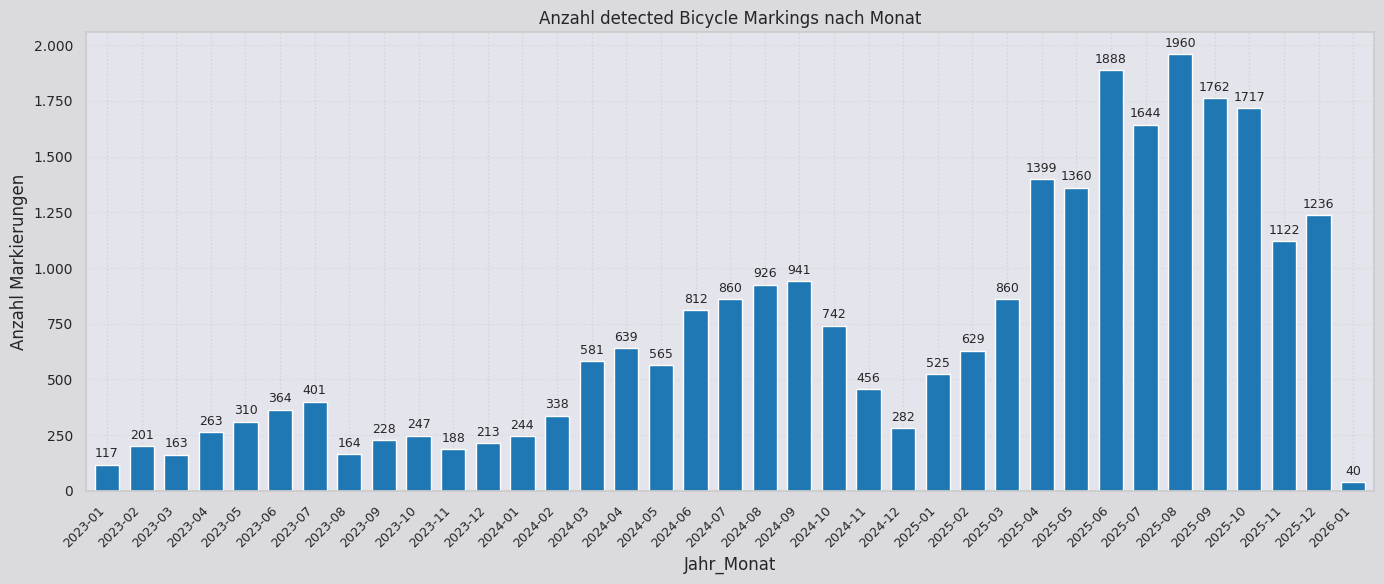

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

df = mapillary_mf_points_cw.copy()
df["month"] = pd.to_datetime(df["last_seen_at"]).dt.to_period("M").dt.to_timestamp()

# Count by month
counts_by_month = df.groupby("month").size()

# === Plot ===
fig, ax = plt.subplots(figsize=(14, 6))
counts_by_month.plot(kind="bar", ax=ax, color="#1f77b4", width=0.7)

# Achsen & Layout
ax.set_xticklabels([d.strftime("%Y-%m") for d in counts_by_month.index], rotation=45, ha="right")
ax.tick_params(axis="x", labelsize=9)

# keine wissenschaftliche Notation
ax.ticklabel_format(style='plain', axis='y')
# Tausenderpunkt (deutsches Schema)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}".replace(",", ".")))

ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
ax.tick_params(axis="y", labelsize=10)

ax.grid(axis="y", linestyle=":", linewidth=0.8, alpha=0.6)

ax.set_xlabel("Jahr_Monat")
ax.set_ylabel("Anzahl Markierungen")
ax.set_title("Anzahl detected Bicycle Markings nach Monat")

# Totals über Balken
for i, (month, total) in enumerate(counts_by_month.items()):
    if total > 0:
        ax.text(i, total + max(counts_by_month)*0.01, str(int(total)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("mk_output/markings_by_month.svg", bbox_inches="tight")
plt.show()


In [41]:
# quick check
print("ml_data_from:", ml_data_from)
print("processed_date:", processed_date)
print("bundeslaender (count):", len(bundeslaender_meta) if isinstance(bundeslaender_meta, dict) else None)

ml_data_from: 2026-01-03T16:17:44.025499+00:00
processed_date: 2026-01-03T21:19:40.795942+00:00
bundeslaender (count): 16


### create readme file

In [42]:
from datetime import datetime
import pandas as pd

# Hole das Dataset-Datum aus ml-mf_metadata.json (Fallback: heute)
if processed_date:
    try:
        last_date = pd.to_datetime(processed_date).strftime("%Y-%m-%d")
    except Exception:
        last_date = datetime.now().strftime("%Y-%m-%d")
else:
    last_date = datetime.now().strftime("%Y-%m-%d")

if ml_data_from:
    try:
        first_date = pd.to_datetime(ml_data_from).strftime("%Y-%m-%d")
    except Exception:
        first_date = "N/A"
else:
    first_date = "N/A"

# Einfache Statistiken
total_count = len(mapillary_mf_points_cw)
date_range = f"{mapillary_mf_points_cw['first_seen_at'].min()} - {mapillary_mf_points_cw['last_seen_at'].max()}"

# === README-Text ===
readme_content = f"""
# Bicycle Marking Detections Output

This folder contains the output file for detected bicycle markings from Mapillary.  
The output has been created on **{last_date}**.

## Overview

- **Total detections**: {total_count}
- **Mapillary dataset from**: {first_date}
- **Detection period**: {date_range}
- **Marking type**: Lane marking - symbol (bicycle)

## Applied Filters

- Only detections with **2+ observations** (min. 180 days apart)
- Only detections seen after **2023-01-01**
- Restricted to **Germany** boundaries

## Output Files

- `mapillary_markings_bicycle_latest.geojson.gz` - Compressed GeoJSON with all markings
- `markings_by_month.svg` - Detection frequency over time

## Statistics Plot

![Anzahl pro Monat](markings_by_month.svg)
"""

# === Datei schreiben ===
with open("mk_output/README.md", "w", encoding="utf-8") as readme_file:
    readme_file.write(readme_content)

print("✅ README.md erfolgreich erstellt!")

✅ README.md erfolgreich erstellt!
